In [1]:
import pandas as pd
import numpy as np


# Visualización de missing values
import missingno as msno

# Visualización
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import sweetviz as sv
%matplotlib inline

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Modelos y evaluacion de metricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

# Calibrar modelo 
from sklearn.calibration import CalibratedClassifierCV


# Guardar modelo
import joblib

# Tema JupyterNotebook
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

#Configuración de  pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Cargar los datos

In [2]:
credit=pd.read_csv("Credit.csv")
credit.head()

,ID,MONTO_CREDITO,SEXO,EDUCACION,ESTADO_CIVIL,EDAD,PAGO_0,PAGO_2,PAGO_3,PAGO_4,PAGO_5,PAGO_6,MONTO_EST_CUENTA1,MONTO_EST_CUENTA2,MONTO_EST_CUENTA3,MONTO_EST_CUENTA4,MONTO_EST_CUENTA5,MONTO_EST_CUENTA6,PAGOS_ANT1,PAGOS_ANT2,PAGOS_ANT3,PAGOS_ANT4,PAGOS_ANT5,PAGOS_ANT6,morosidad.mes.siguiente
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


#### EDA (Exploratory Data Analysis)

In [3]:
# Check los missing values
credit.isnull().sum()

ID                         0
MONTO_CREDITO              0
SEXO                       0
EDUCACION                  0
ESTADO_CIVIL               0
EDAD                       0
PAGO_0                     0
PAGO_2                     0
PAGO_3                     0
PAGO_4                     0
PAGO_5                     0
PAGO_6                     0
MONTO_EST_CUENTA1          0
MONTO_EST_CUENTA2          0
MONTO_EST_CUENTA3          0
MONTO_EST_CUENTA4          0
MONTO_EST_CUENTA5          0
MONTO_EST_CUENTA6          0
PAGOS_ANT1                 0
PAGOS_ANT2                 0
PAGOS_ANT3                 0
PAGOS_ANT4                 0
PAGOS_ANT5                 0
PAGOS_ANT6                 0
morosidad.mes.siguiente    0
dtype: int64

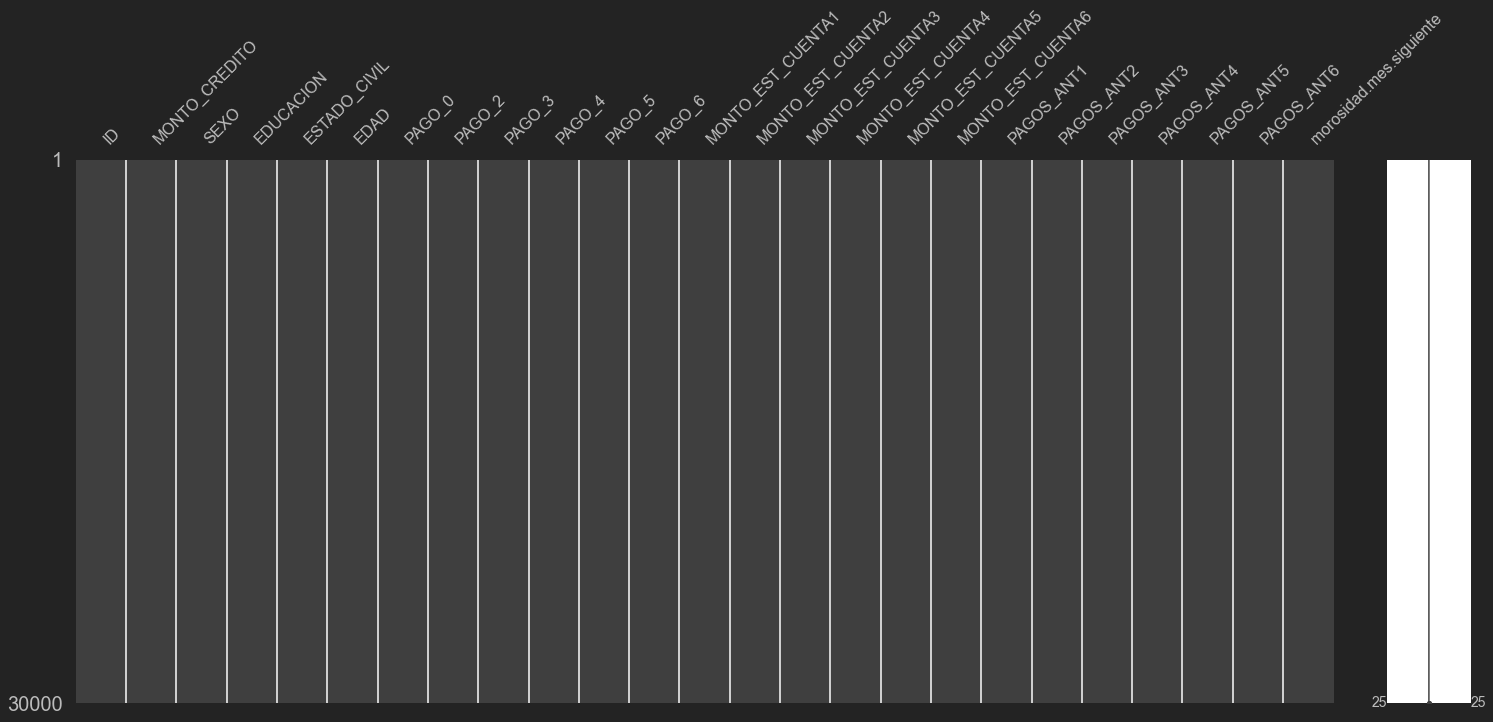

In [4]:
msno.matrix(credit)

#### Comprobando el balance de la data

In [5]:
print('El número por incumplimento de pago son: ' + str(credit['morosidad.mes.siguiente'].value_counts()[0]) + ' lo que es el', round(credit['morosidad.mes.siguiente'].value_counts()[0]/len(credit) * 100,2), '% del dataset')
print('El número por cumplimiento de pago son: ' + str(credit['morosidad.mes.siguiente'].value_counts()[1]) + ' lo que es el', round(credit['morosidad.mes.siguiente'].value_counts()[1]/len(credit) * 100,2), '% del dataset')

El número por incumplimento de pago son: 23364 lo que es el 77.88 % del dataset
El número por cumplimiento de pago son: 6636 lo que es el 22.12 % del dataset


Se puede observar que hay un desequilibrio en el conjunto de datos. Este problema se arreglará más adelante. A continuación se presenta una imagen que sustenta lo anterior.

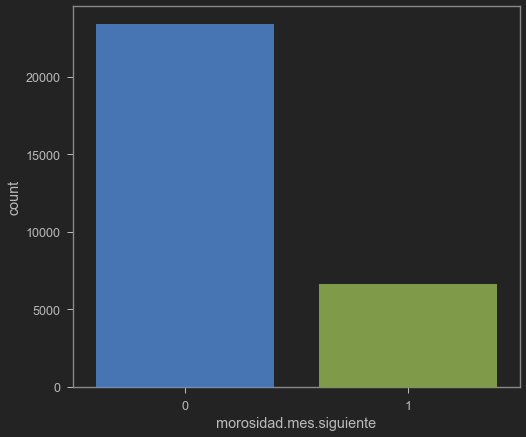

In [6]:
sns.countplot(x='morosidad.mes.siguiente', data=credit)

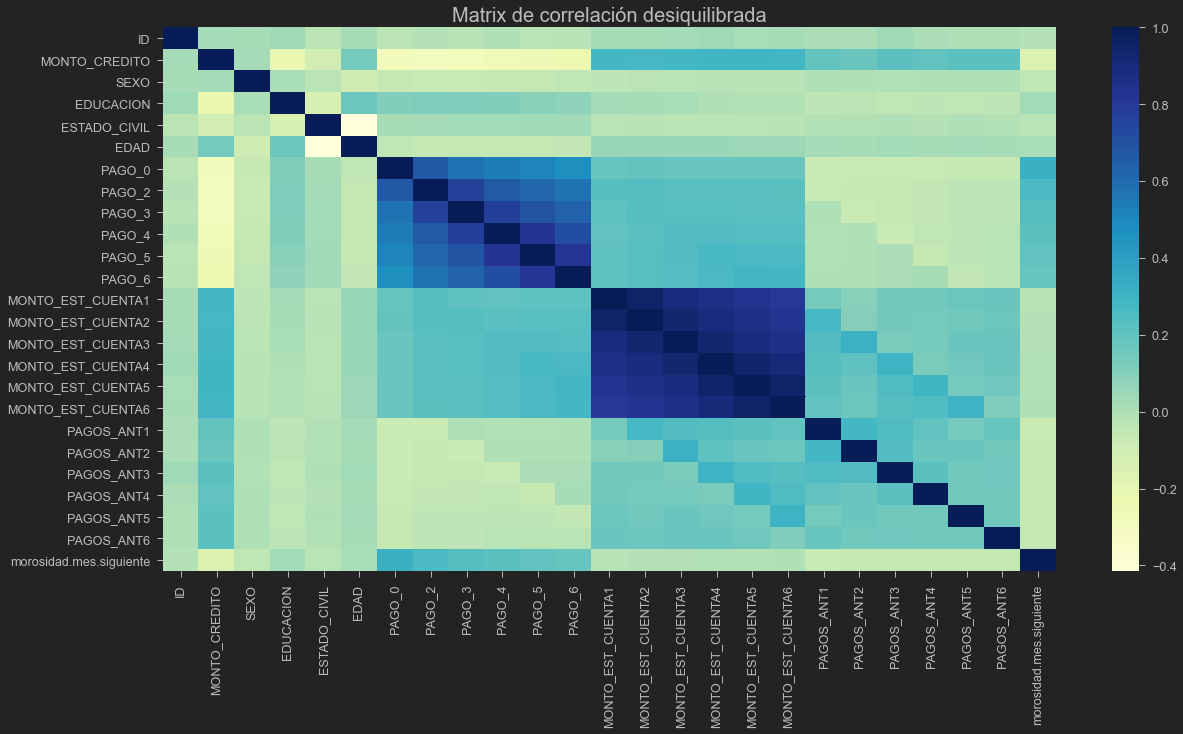

In [7]:
# Medidas del grafico
fig, ax = plt.subplots(figsize=(20,10))         

# Graficar la matrix
corr = credit.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Matrix de correlación desiquilibrada", fontsize=20)

plt.show()

In [8]:
#my_report = sv.analyze(credit)
#my_report.show_html('Report_desquilibrado.html')

### Feature Engineering

**1. Escalar los datos:** Se usa **RobustScaler** ya es resistente a los valores atípicos y sabe manejarlos dado el caso que se presenten en el conjunto de datos.

In [9]:
def escalador(data):
    """
    escalador: Esta función escala los datos con RobustScaler
    
    Return
    ------
    data: Dataframe con las variables numericas escaladas
    
    """
    from sklearn.preprocessing import RobustScaler
    
    # Columnas para escalar
    columns = ['MONTO_EST_CUENTA1', 'MONTO_EST_CUENTA2', 'MONTO_EST_CUENTA3', 
               'MONTO_EST_CUENTA4', 'MONTO_EST_CUENTA5', 'MONTO_EST_CUENTA6', 
               'PAGOS_ANT1', 'PAGOS_ANT2', 'PAGOS_ANT3', 'PAGOS_ANT4', 'PAGOS_ANT5', 'PAGOS_ANT6']
    
    Scaler = RobustScaler()
    data[columns] = Scaler.fit_transform(data[columns])
    
    return data   
    

In [10]:
data_escalada = escalador(credit)
data_escalada.head()

,ID,MONTO_CREDITO,SEXO,EDUCACION,ESTADO_CIVIL,EDAD,PAGO_0,PAGO_2,PAGO_3,PAGO_4,PAGO_5,PAGO_6,MONTO_EST_CUENTA1,MONTO_EST_CUENTA2,MONTO_EST_CUENTA3,MONTO_EST_CUENTA4,MONTO_EST_CUENTA5,MONTO_EST_CUENTA6,PAGOS_ANT1,PAGOS_ANT2,PAGOS_ANT3,PAGOS_ANT4,PAGOS_ANT5,PAGOS_ANT6,morosidad.mes.siguiente
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,-0.290695,-0.296584,-0.337391,-0.365126,-0.373848,-0.356074,-0.524214,-0.316775,-0.437424,-0.403524,-0.396930,-0.386374,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,-0.310071,-0.319150,-0.302730,-0.302419,-0.302504,-0.288055,-0.524214,-0.242141,-0.194411,-0.134508,-0.396930,0.128791,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,0.107937,-0.117549,-0.113559,-0.090477,-0.065180,-0.031747,-0.145282,-0.122150,-0.194411,-0.134508,-0.132310,0.901539,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,0.387339,0.443008,0.507883,0.177504,0.224139,0.260230,-0.024963,0.002400,-0.145808,-0.107606,-0.114051,-0.128791,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,-0.216654,-0.254500,0.273859,0.036183,0.021506,0.042968,-0.024963,8.320614,1.992710,2.017621,-0.214607,-0.211475,0


#### Solución del problema de desequilibrio

<img src="resampling.png">

<br>

El **sobremuestreo (Oversampling)** aleatorio implica la duplicación aleatoria de ejemplos de la clase minoritaria y su adición al conjunto de datos de entrenamiento.

<br>

El **submuestreo (Undersampling)** aleatorio implica la selección aleatoria de ejemplos de la clase mayoritaria para eliminarlos del conjunto de datos de entrenamiento.

<br>
Para este proyecto se utilizará este último. A continuación se observa una función que hace el procedimiento.

In [11]:
def undersampling_data(data):
    """
    undersampling_data : Recibe un dataframe que se encuentra desquilibrado y retorna un dataframe equilibrado 
                         con igual numero de clases
    
    Return
    ------
    data: Dataframe equilibrado con igual numero de clases
    
    """
    # Datos aleatorios.
    shuffled_df = data.sample(frac=1,random_state=4)

    # Cantidad de clases a escoger. Se especifica la clase que tiene menos datos
    morosos_dt = shuffled_df.loc[shuffled_df['morosidad.mes.siguiente'] == 1]

    # Seleccionar aleatoriamente el numero de datos. Se especifica la clase que tiene mas datos
    rows = data['morosidad.mes.siguiente'].value_counts()[1]
    no_morosos_dt = shuffled_df.loc[shuffled_df['morosidad.mes.siguiente'] == 0].sample(n=rows,random_state=42)
    normalized_df = pd.concat([morosos_dt, no_morosos_dt])
    
    return normalized_df   
    

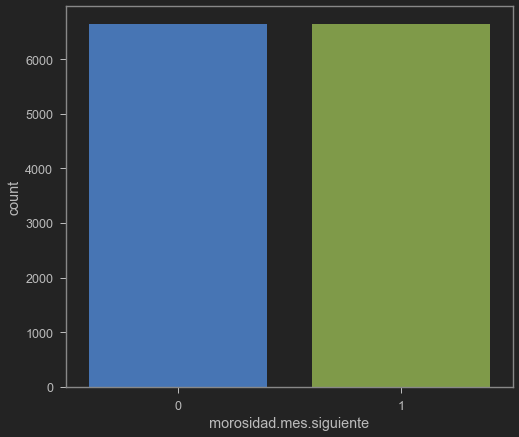

In [12]:
data_normalizada = undersampling_data(data_escalada)
sns.countplot(x='morosidad.mes.siguiente', data=data_normalizada)

In [13]:
print('El número por incumplimento de pago son: ' + str(data_normalizada['morosidad.mes.siguiente'].value_counts()[0]) + ' lo que es el', round(data_normalizada['morosidad.mes.siguiente'].value_counts()[0]/len(data_normalizada) * 100,2), '% del dataset')
print('El número por cumplimiento de pago son: ' + str(data_normalizada['morosidad.mes.siguiente'].value_counts()[1]) + ' lo que es el', round(data_normalizada['morosidad.mes.siguiente'].value_counts()[1]/len(data_normalizada) * 100,2), '% del dataset')

El número por incumplimento de pago son: 6636 lo que es el 50.0 % del dataset
El número por cumplimiento de pago son: 6636 lo que es el 50.0 % del dataset


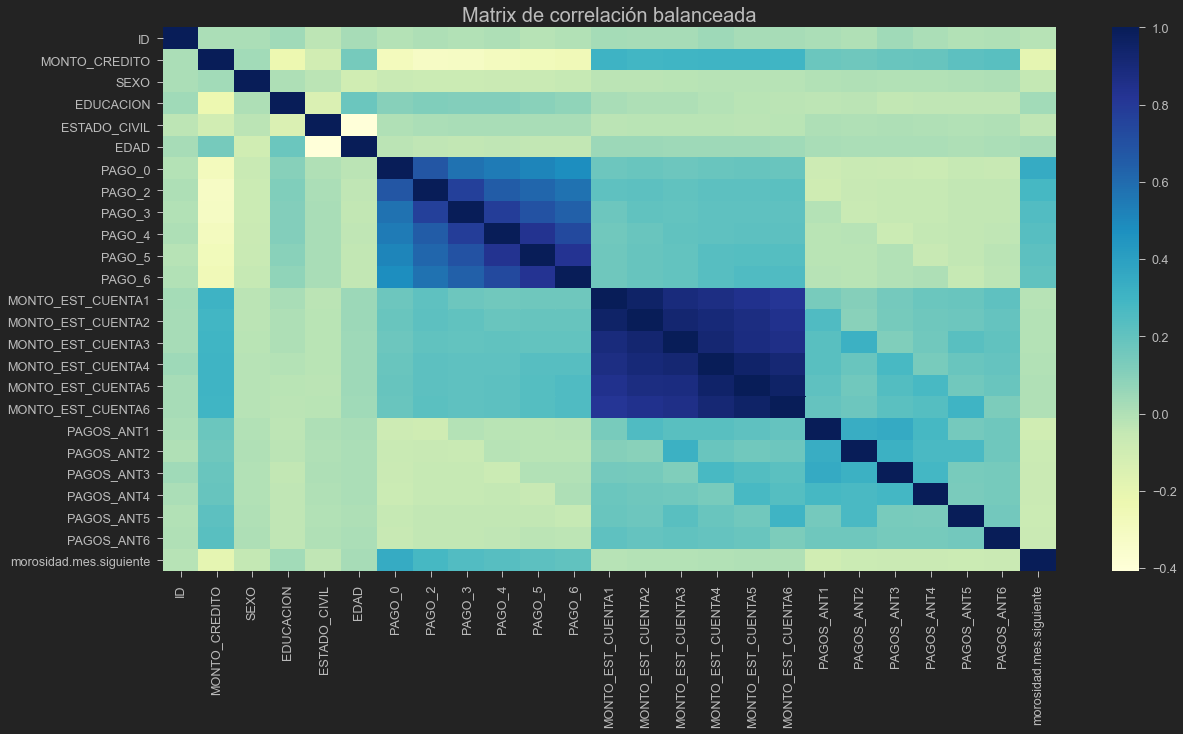

In [14]:
fig, ax = plt.subplots(figsize=(20,10))         

# Matrix de correlación balanceada
corr = data_normalizada.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Matrix de correlación balanceada", fontsize=20)

plt.show()

Hay pequeñas difencias en las matrices de relación de los dos dataframes. Para ello se generá dos reportes donde se puede apreciar con mayor exactitud las diferencias. 

In [15]:
#my_report = sv.analyze(data_normalizada)

In [16]:
#my_report.show_html('Report_normalizada.html')

#### Valores atípícos

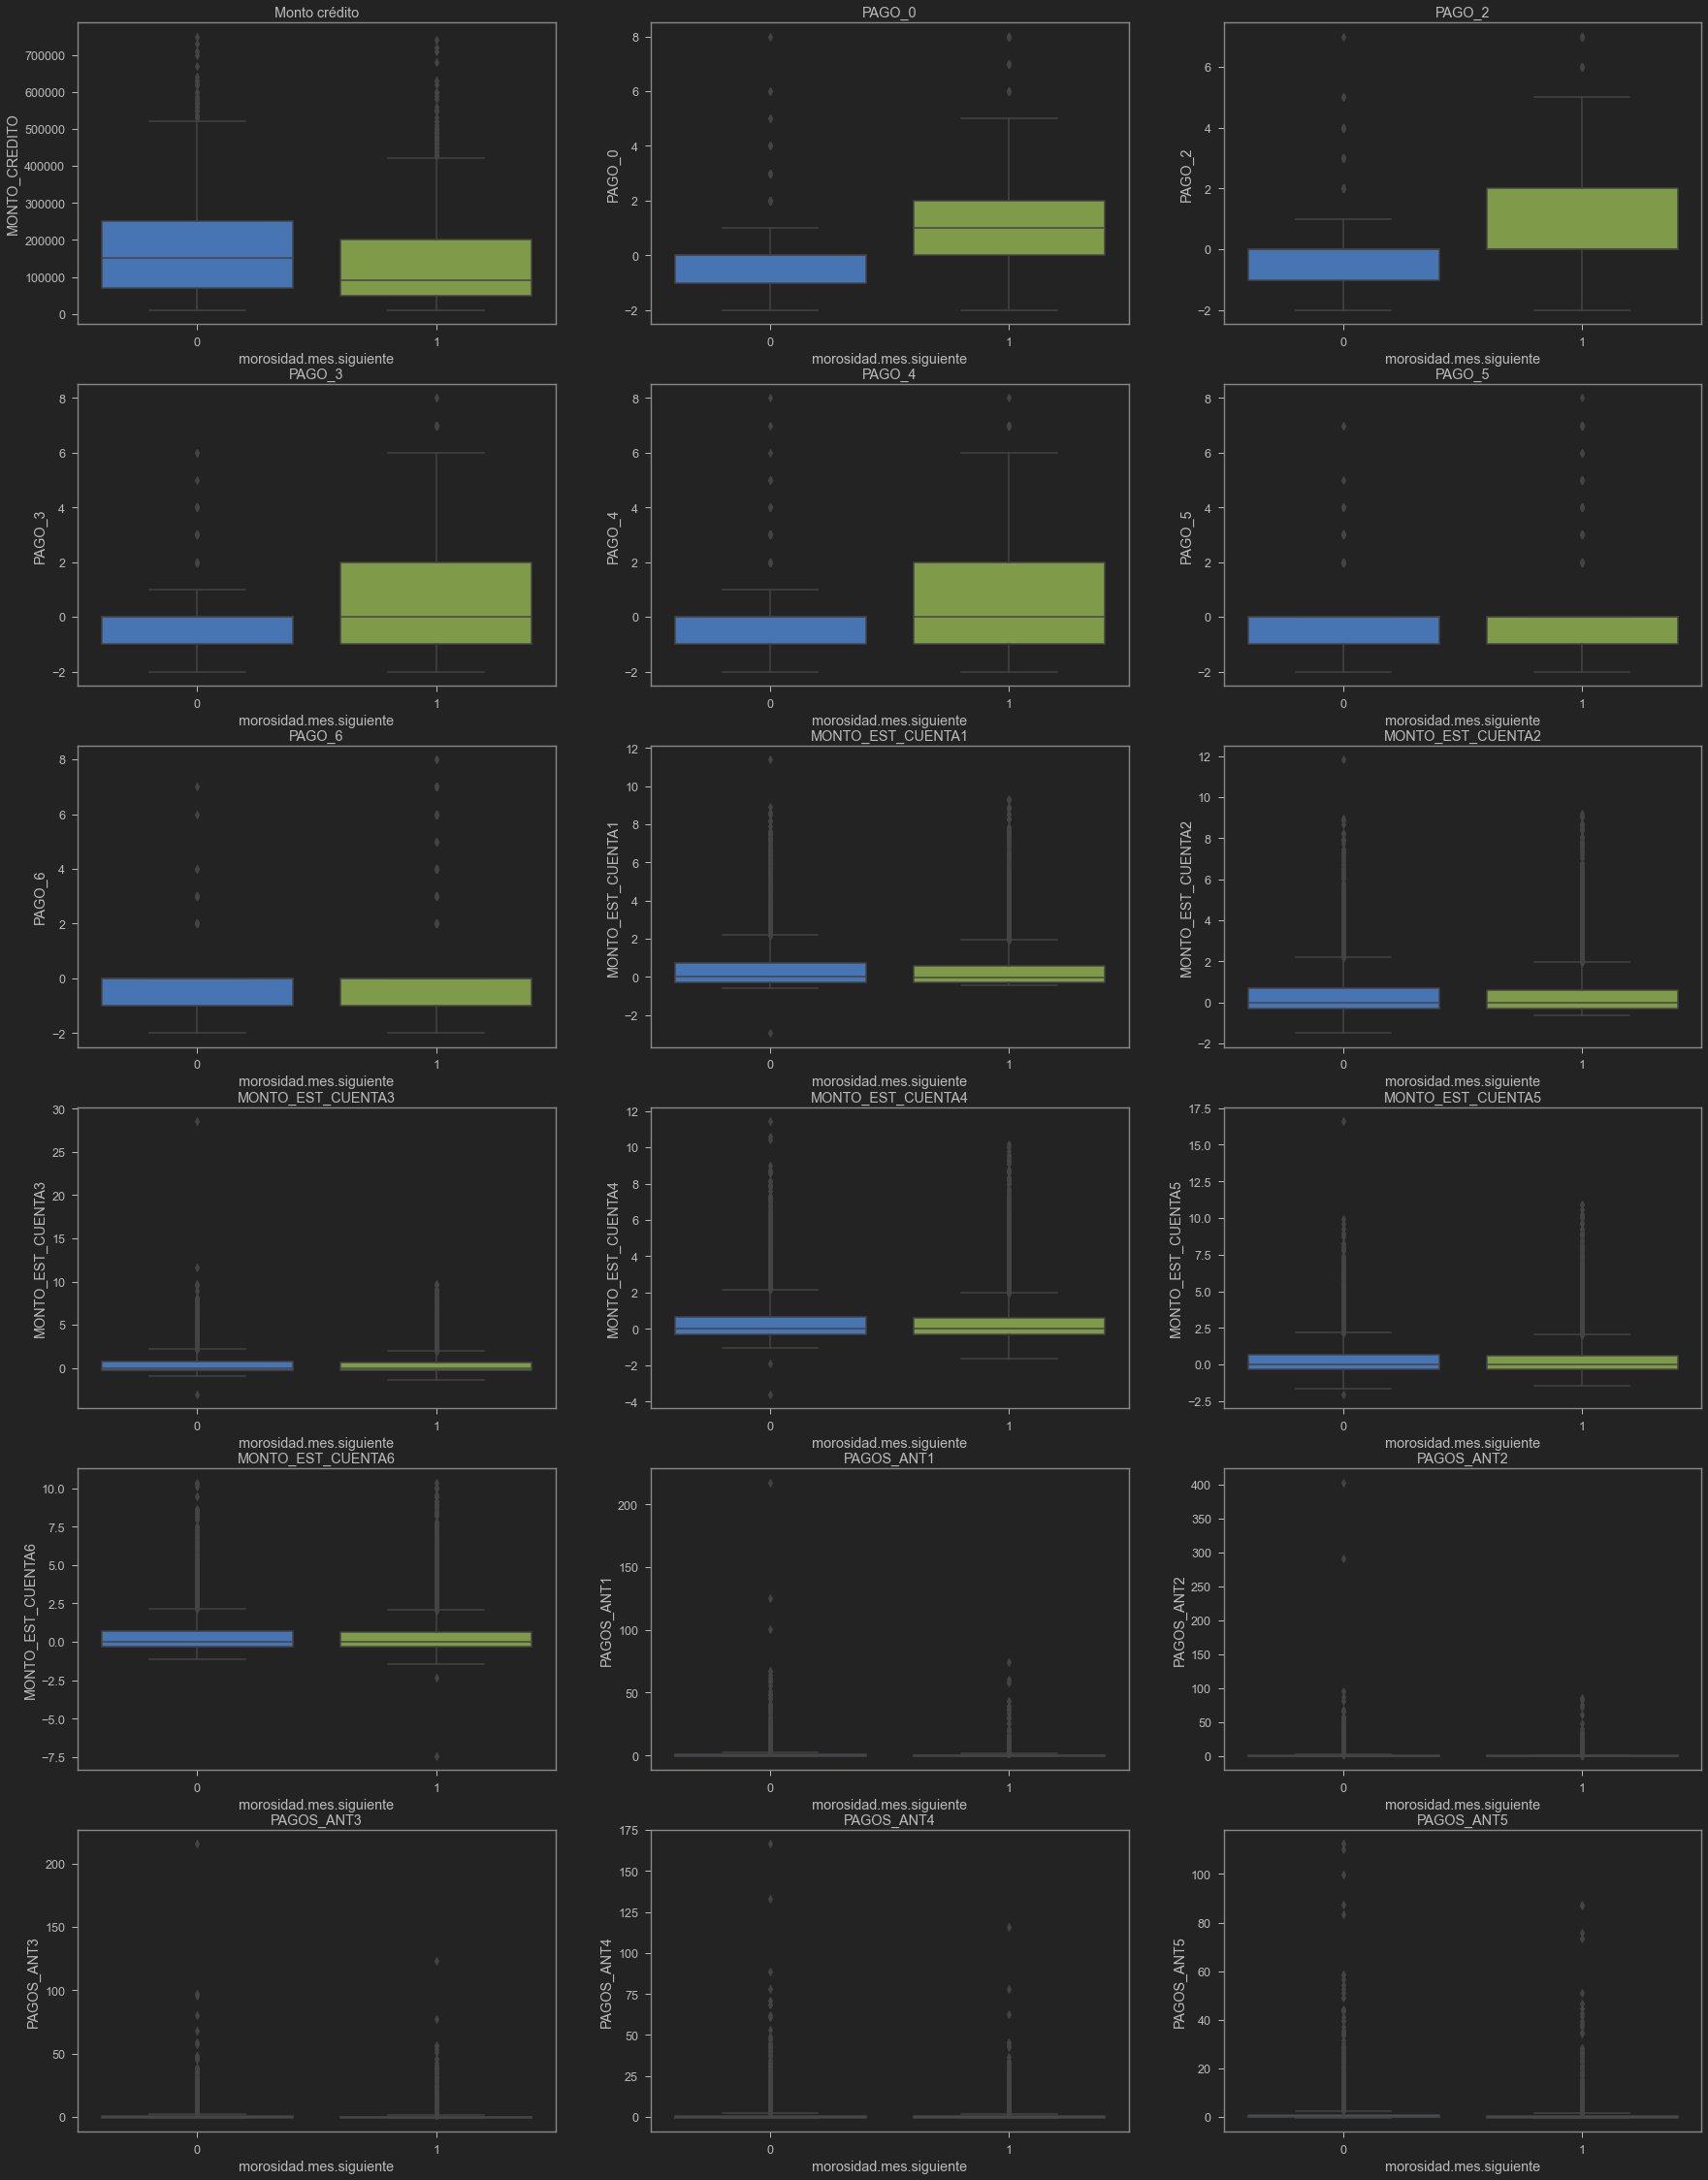

In [17]:
# Tamaño de los graficos
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(30,40))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_CREDITO", data=data_normalizada, ax=axes[0][0])
axes[0][0].set_title('Monto crédito')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_0", data=data_normalizada, ax=axes[0][1])
axes[0][1].set_title('PAGO_0')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_2", data=data_normalizada, ax=axes[0][2])
axes[0][2].set_title('PAGO_2')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_3", data=data_normalizada, ax=axes[1][0])
axes[1][0].set_title('PAGO_3')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_4", data=data_normalizada, ax=axes[1][1])
axes[1][1].set_title('PAGO_4')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_5", data=data_normalizada, ax=axes[1][2])
axes[1][2].set_title('PAGO_5')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGO_6", data=data_normalizada, ax=axes[2][0])
axes[2][0].set_title('PAGO_6')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA1", data=data_normalizada, ax=axes[2][1])
axes[2][1].set_title('MONTO_EST_CUENTA1')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA2", data=data_normalizada, ax=axes[2][2])
axes[2][2].set_title('MONTO_EST_CUENTA2')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA3", data=data_normalizada, ax=axes[3][0])
axes[3][0].set_title('MONTO_EST_CUENTA3')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA4", data=data_normalizada, ax=axes[3][1])
axes[3][1].set_title('MONTO_EST_CUENTA4')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA5", data=data_normalizada, ax=axes[3][2])
axes[3][2].set_title('MONTO_EST_CUENTA5')

sns.boxplot(x="morosidad.mes.siguiente", y="MONTO_EST_CUENTA6", data=data_normalizada, ax=axes[4][0])
axes[4][0].set_title('MONTO_EST_CUENTA6')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGOS_ANT1", data=data_normalizada, ax=axes[4][1])
axes[4][1].set_title('PAGOS_ANT1')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGOS_ANT2", data=data_normalizada, ax=axes[4][2])
axes[4][2].set_title('PAGOS_ANT2')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGOS_ANT3", data=data_normalizada, ax=axes[5][0])
axes[5][0].set_title('PAGOS_ANT3')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGOS_ANT4", data=data_normalizada, ax=axes[5][1])
axes[5][1].set_title('PAGOS_ANT4')

sns.boxplot(x="morosidad.mes.siguiente", y="PAGOS_ANT5", data=data_normalizada, ax=axes[5][2])
axes[5][2].set_title('PAGOS_ANT5')

plt.show()



In [18]:
data_normalizada.head()

,ID,MONTO_CREDITO,SEXO,EDUCACION,ESTADO_CIVIL,EDAD,PAGO_0,PAGO_2,PAGO_3,PAGO_4,PAGO_5,PAGO_6,MONTO_EST_CUENTA1,MONTO_EST_CUENTA2,MONTO_EST_CUENTA3,MONTO_EST_CUENTA4,MONTO_EST_CUENTA5,MONTO_EST_CUENTA6,PAGOS_ANT1,PAGOS_ANT2,PAGOS_ANT3,PAGOS_ANT4,PAGOS_ANT5,PAGOS_ANT6,morosidad.mes.siguiente
25548,25549,30000.0,2,2,2,49,2,2,2,2,2,2,-0.074206,-0.042985,-0.036479,0.021656,0.030055,0.086980,-0.149775,-0.482121,0.170109,-0.403524,0.132310,-0.386374,1
24139,24140,100000.0,1,1,2,29,-1,0,-1,-1,0,-1,-0.341094,-0.328720,-0.345722,-0.350178,-0.365794,-0.336676,-0.274588,-0.294936,0.031592,-0.403524,-0.150834,-0.386374,1
14865,14866,20000.0,1,2,1,32,0,0,0,0,0,0,-0.083037,-0.047819,-0.011557,0.002990,0.030881,0.061094,-0.160260,-0.098152,-0.344107,-0.298070,-0.291082,-0.386374,1
15768,15769,50000.0,2,3,2,23,0,0,0,0,0,0,0.201103,0.215727,0.245632,0.284289,0.306117,0.364564,-0.138792,-0.035517,0.049575,-0.047347,0.600159,-0.386116,1
9488,9489,90000.0,1,3,2,25,0,0,0,0,-2,-2,-0.244907,-0.232787,-0.212258,-0.365126,-0.373848,-0.356074,-0.231653,-0.227502,-0.437424,-0.403524,-0.396930,-0.336660,1


In [19]:
# Eliminar columna index y la columna ID
data_normalizada.reset_index(drop=True, inplace=True)
data_normalizada.drop(['ID'], axis=1, inplace=True)

data_normalizada.head()

,MONTO_CREDITO,SEXO,EDUCACION,ESTADO_CIVIL,EDAD,PAGO_0,PAGO_2,PAGO_3,PAGO_4,PAGO_5,PAGO_6,MONTO_EST_CUENTA1,MONTO_EST_CUENTA2,MONTO_EST_CUENTA3,MONTO_EST_CUENTA4,MONTO_EST_CUENTA5,MONTO_EST_CUENTA6,PAGOS_ANT1,PAGOS_ANT2,PAGOS_ANT3,PAGOS_ANT4,PAGOS_ANT5,PAGOS_ANT6,morosidad.mes.siguiente
0,30000.0,2,2,2,49,2,2,2,2,2,2,-0.074206,-0.042985,-0.036479,0.021656,0.030055,0.086980,-0.149775,-0.482121,0.170109,-0.403524,0.132310,-0.386374,1
1,100000.0,1,1,2,29,-1,0,-1,-1,0,-1,-0.341094,-0.328720,-0.345722,-0.350178,-0.365794,-0.336676,-0.274588,-0.294936,0.031592,-0.403524,-0.150834,-0.386374,1
2,20000.0,1,2,1,32,0,0,0,0,0,0,-0.083037,-0.047819,-0.011557,0.002990,0.030881,0.061094,-0.160260,-0.098152,-0.344107,-0.298070,-0.291082,-0.386374,1
3,50000.0,2,3,2,23,0,0,0,0,0,0,0.201103,0.215727,0.245632,0.284289,0.306117,0.364564,-0.138792,-0.035517,0.049575,-0.047347,0.600159,-0.386116,1
4,90000.0,1,3,2,25,0,0,0,0,-2,-2,-0.244907,-0.232787,-0.212258,-0.365126,-0.373848,-0.356074,-0.231653,-0.227502,-0.437424,-0.403524,-0.396930,-0.336660,1


In [20]:
# Dividir en elementos de entrada y salida
X, y = data_normalizada.iloc[:, :-1], data_normalizada.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Imprime las dimensiones
with_outilers = X_train.shape[0]
print(X_train.shape, y_train.shape)

# Identifica valores atípicos en el conjunto de datos de entrenamiento
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

# Selecciona todas las filas que no sean valores atípicos
mask = yhat != -1
X_train, y_train = X_train.iloc[mask, :], y_train.iloc[mask]
without_outliers = X_train.shape[0]

# Imprime las dimensiones
print(X_train.shape, y_train.shape)

print(f"En total se detectaron {with_outilers - without_outliers} valores atípicos en el dataset.")

(9290, 23) (9290,)
(8361, 23) (8361,)
En total se detectaron 929 valores atípicos en el dataset.


In [21]:
clf0 = LogisticRegression(random_state=10)
clf0.fit(X_train, y_train)

y_pred = clf0.predict(X_test)
accuracy_regr=accuracy_score(y_test, y_pred)
precision_regr=precision_score(y_test, y_pred,average='weighted')
recall_regr=recall_score(y_test, y_pred,average='weighted')
f1_regr=f1_score(y_test,y_pred,average='weighted')

print("accuracy:", accuracy_regr)
print("Precision:", precision_regr)
print("Recall:", recall_regr)
print('f1_score:',f1_regr)

accuracy: 0.4977398292315419
Precision: 0.24774493760344454
Recall: 0.4977398292315419
f1_score: 0.3308250642310249


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
my_dict = {}

my_dict['ac'] = 32
my_dict['f1'] = 32

print(my_dict)


{'ac': 32, 'f1': 32}


### Implementación de algoritmos

<br> 

##### 1) Regresión logistica

In [23]:
def log_regr(X_train, X_test, y_train, y_test):
    """
    log_regr: Esta función implementa el algoritmo de regresión logística y guarda en un diccionario las metricas
    
    Return
    ------
    metrics: Retorna un diccinario con las metricas del modelo implementado.
    
    """
    clf = LogisticRegression(random_state=10)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Guardar metricas en un diccionario
    metrics = {}
    
    metrics ['clf'] = clf
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics ['precision'] = precision_score(y_test, y_pred,average='weighted')
    metrics ['recall'] = recall_score(y_test, y_pred,average='weighted')
    metrics ['f1'] = f1_score(y_test,y_pred,average='weighted')
    
    return metrics

log_reg_result = log_regr(X_train, X_test, y_train, y_test)
log_reg_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'clf': LogisticRegression(random_state=10),
 'accuracy': 0.4977398292315419,
 'precision': 0.24774493760344454,
 'recall': 0.4977398292315419,
 'f1': 0.3308250642310249}

##### 2) Random Forest

In [24]:
def r_forest(X_train, X_test, y_train, y_test):
    """
    r_forest: Esta función implementa el algoritmo de random forest y guarda en un diccionario las metricas
    
    Return
    ------
    metrics: Retorna un diccinario con las metricas del modelo implementado.
    
    """    
    clf = RandomForestClassifier(random_state=10)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Guardar metricas en un diccionario
    metrics = {}
    
    metrics ['clf'] = clf
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics ['precision'] = precision_score(y_test, y_pred,average='weighted')
    metrics ['recall'] = recall_score(y_test, y_pred,average='weighted')
    metrics ['f1'] = f1_score(y_test,y_pred,average='weighted')
    
    return metrics

r_forest_result = r_forest(X_train, X_test, y_train, y_test)
r_forest_result

{'clf': RandomForestClassifier(random_state=10),
 'accuracy': 0.702913108990457,
 'precision': 0.7057870056206829,
 'recall': 0.702913108990457,
 'f1': 0.7020052465862333}

In [25]:
r_forest_result.get('clf')

RandomForestClassifier(random_state=10)

##### 3) Gradient Boosting

In [26]:
def g_boosting(X_train, X_test, y_train, y_test):
    """
    g_boosting: Esta función implementa el algoritmo de Gradient Boosting y guarda en un diccionario las metricas
    
    Return
    ------
    metrics: Retorna un diccinario con las metricas del modelo implementado.
    
    """    
    clf = GradientBoostingClassifier(random_state=10)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Guardar metricas en un diccionario
    metrics = {}
    
    metrics ['clf'] = clf
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics ['precision'] = precision_score(y_test, y_pred,average='weighted')
    metrics ['recall'] = recall_score(y_test, y_pred,average='weighted')
    metrics ['f1'] = f1_score(y_test,y_pred,average='weighted')
    
    return metrics

g_boosting_result = g_boosting(X_train, X_test, y_train, y_test)
g_boosting_result

{'clf': GradientBoostingClassifier(random_state=10),
 'accuracy': 0.715971873430437,
 'precision': 0.7187571028637086,
 'recall': 0.715971873430437,
 'f1': 0.7151813641377788}

##### 4) Ada Boost

In [27]:
def ada_boost(X_train, X_test, y_train, y_test):
    """
    ada_boost: Esta función implementa el algoritmo de ada boosting y guarda en un diccionario las metricas
    
    Return
    ------
    metrics: Retorna un diccinario con las metricas del modelo implementado.
    
    """    
    clf = AdaBoostClassifier(random_state=10)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Guardar metricas en un diccionario
    metrics = {}
    
    metrics ['clf'] = clf
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics ['precision'] = precision_score(y_test, y_pred,average='weighted')
    metrics ['recall'] = recall_score(y_test, y_pred,average='weighted')
    metrics ['f1'] = f1_score(y_test,y_pred,average='weighted')
    
    return metrics

ada_boost_result = ada_boost(X_train, X_test, y_train, y_test)
ada_boost_result

{'clf': AdaBoostClassifier(random_state=10),
 'accuracy': 0.7066800602712205,
 'precision': 0.7112868669025436,
 'recall': 0.7066800602712205,
 'f1': 0.705234964548435}

##### 5)  Voting

In [28]:
def voting(X_train, X_test, y_train, y_test, rf, gb, ad):
    """
    voting: Esta función implementa varios algoritmos y guarda en un diccionario las metricas
    
    Return
    ------
    metrics: Retorna un diccinario con las metricas del modelo implementado.
    
    """    
    clf = VotingClassifier(estimators=[('rf',rf),('gb', gb),('ab',ad)])
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    # Guardar metricas en un diccionario
    metrics = {}
    
    metrics ['clf'] = clf
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics ['precision'] = precision_score(y_test, y_pred,average='weighted')
    metrics ['recall'] = recall_score(y_test, y_pred,average='weighted')
    metrics ['f1'] = f1_score(y_test,y_pred,average='weighted')
    
    return metrics

voting_result = voting(X_train, X_test, y_train, y_test,
                       r_forest_result.get('clf'), g_boosting_result.get('clf'),
                       ada_boost_result.get('clf'))
voting_result

{'clf': VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=10)),
                              ('gb',
                               GradientBoostingClassifier(random_state=10)),
                              ('ab', AdaBoostClassifier(random_state=10))]),
 'accuracy': 0.7129583124058262,
 'precision': 0.7167326417783146,
 'recall': 0.7129583124058262,
 'f1': 0.7118423724703056}

Con el objetivo de graficar cada uno de los resultados cada una de las metricas se almaceneran en una lista.

In [29]:
# Todos los scores en una lista
accuracy=[]
accuracy.append(log_reg_result.get('accuracy'))
accuracy.append(r_forest_result.get('accuracy'))
accuracy.append(g_boosting_result.get('accuracy'))
accuracy.append(ada_boost_result.get('accuracy'))
accuracy.append(voting_result.get('accuracy'))

In [30]:
precision=[]
precision.append(log_reg_result.get('precision'))
precision.append(r_forest_result.get('precision'))
precision.append(g_boosting_result.get('precision'))
precision.append(ada_boost_result.get('precision'))
precision.append(voting_result.get('precision'))

In [31]:
recall=[]
recall.append(log_reg_result.get('recall'))
recall.append(r_forest_result.get('recall'))
recall.append(g_boosting_result.get('recall'))
recall.append(ada_boost_result.get('recall'))
recall.append(voting_result.get('recall'))

In [32]:
f1=[]
f1.append(log_reg_result.get('f1'))
f1.append(r_forest_result.get('f1'))
f1.append(g_boosting_result.get('f1'))
f1.append(ada_boost_result.get('f1'))
f1.append(voting_result.get('f1'))

In [33]:
print(accuracy)
print(precision)
print(recall)
print(f1)

[0.4977398292315419, 0.702913108990457, 0.715971873430437, 0.7066800602712205, 0.7129583124058262]
[0.24774493760344454, 0.7057870056206829, 0.7187571028637086, 0.7112868669025436, 0.7167326417783146]
[0.4977398292315419, 0.702913108990457, 0.715971873430437, 0.7066800602712205, 0.7129583124058262]
[0.3308250642310249, 0.7020052465862333, 0.7151813641377788, 0.705234964548435, 0.7118423724703056]


##### Graficar los resultados de las metricas

<br>

###### Acurracy

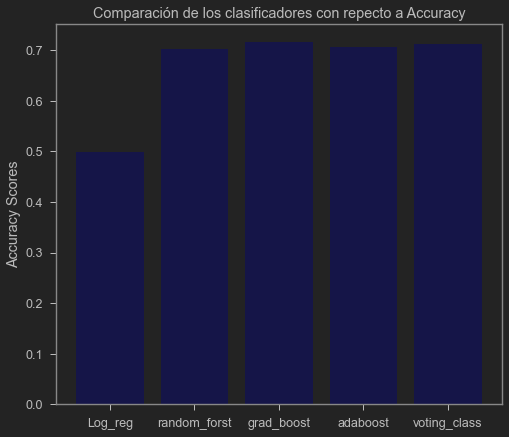

In [34]:
classifier_names=('Log_reg','random_forst','grad_boost','adaboost','voting_class')
y_axis=np.arange(len(classifier_names))

plt.bar(y_axis, accuracy, alpha=0.4, color='navy', ecolor='navy')
plt.xticks(y_axis, classifier_names)
plt.ylabel('Accuracy Scores')
plt.title('Comparación de los clasificadores con repecto a Accuracy')

plt.show()

###### Precision

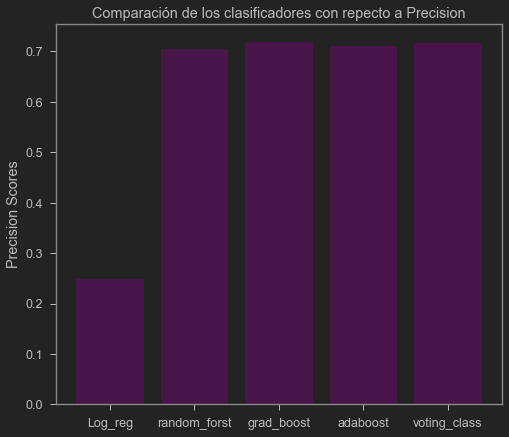

In [35]:
classifier_names=('Log_reg','random_forst','grad_boost','adaboost','voting_class')
y_axis=np.arange(len(classifier_names))

plt.bar(y_axis, precision, alpha=0.4,color='purple',ecolor='darkgreen')
plt.xticks(y_axis, classifier_names)
plt.ylabel('Precision Scores')
plt.title('Comparación de los clasificadores con repecto a Precision')

plt.show()

###### Recall

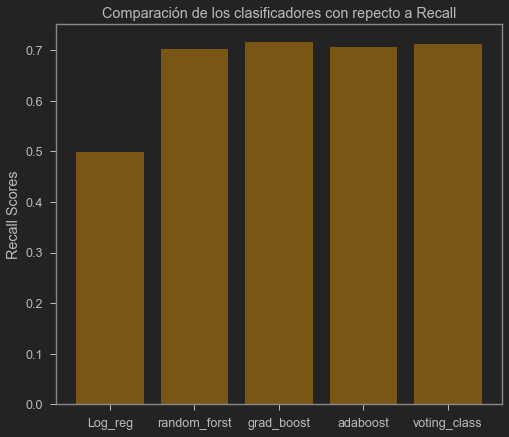

In [36]:
classifier_names=('Log_reg','random_forst','grad_boost','adaboost','voting_class')
y_axis=np.arange(len(classifier_names))

plt.bar(y_axis, recall, alpha=0.4,color='orange',ecolor='black')
plt.xticks(y_axis, classifier_names)
plt.ylabel('Recall Scores')
plt.title('Comparación de los clasificadores con repecto a Recall')

plt.show()

###### f1

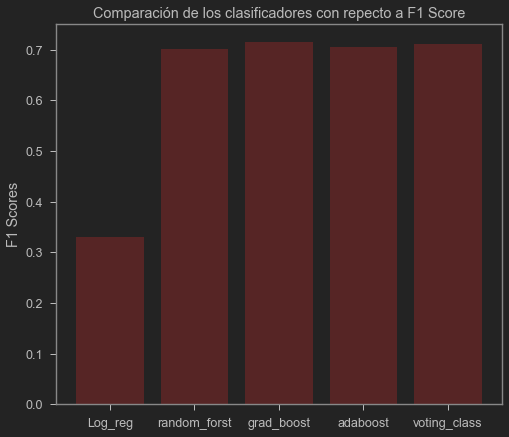

In [37]:
classifier_names=('Log_reg','random_forst','grad_boost','adaboost','voting_class')
y_axis=np.arange(len(classifier_names))

plt.bar(y_axis, f1, alpha=0.4,color='brown',ecolor='black')
plt.xticks(y_axis, classifier_names)
plt.ylabel('F1 Scores')
plt.title('Comparación de los clasificadores con repecto a F1 Score')

plt.show()

#### Ajustes de hiperparametros

<br>

###### Randon Forest


In [38]:
# Parametros para Randon Forest y Gradient Boosting
parameters ={'n_estimators' :[15, 30, 45, 50],
             'min_samples_split' :[3,10, 15, 30, 50]
}

# Búsqueda exhaustiva de valores de parámetros especificados para Randon Forest. 
cl_RF = GridSearchCV(RandomForestClassifier(random_state=10), cv=10, param_grid=parameters,scoring='accuracy')
cl_RF.fit(X_train,y_train)
print("Best parameters for RandomForest:",cl_RF.best_params_)

Best parameters for RandomForest: {'min_samples_split': 50, 'n_estimators': 50}


###### Gradient Boosting

In [39]:
# Búsqueda exhaustiva de valores de parámetros especificados para Gradient Boosting.
clf_GB = GridSearchCV(GradientBoostingClassifier(random_state=10), cv=10, param_grid=parameters, scoring='accuracy')
clf_GB.fit(X_train,y_train)
print("Best parameters for GradeintBoosting:",clf_GB.best_params_)

Best parameters for GradeintBoosting: {'min_samples_split': 3, 'n_estimators': 50}


###### AdaBoost

In [40]:
parameters_ada ={'n_estimators' :[15, 30, 45, 50]}

# Búsqueda exhaustiva de valores de parámetros especificados para AdaBoost.
clf_AB = GridSearchCV(AdaBoostClassifier(random_state=10), parameters_ada,cv=10,scoring='accuracy')
clf_AB.fit(X_train, y_train)
print("Best parameters for Adaboost:",clf_AB.best_params_)

Best parameters for Adaboost: {'n_estimators': 30}


A continuación, se utilizará los resultados anteriores para Voting CLassifier. Para ello, se calibra cada uno de los clasificadores con  [Isotonic](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)

<br>

**CalibratedClassifierCV**: Es un calibrador de probabilidad con regresión isotónica o regresión logística.

In [44]:
clf_VC1 = RandomForestClassifier(n_estimators=50, min_samples_split=50, random_state=10)
clf_VC2 = GradientBoostingClassifier(n_estimators=50, min_samples_split=3, random_state=10)
clf_VC3 = AdaBoostClassifier(n_estimators=30, random_state=10)


clf_isotonic1 = CalibratedClassifierCV(clf_VC1, method='isotonic', cv=10)
clf_isotonic2 = CalibratedClassifierCV(clf_VC2, method='isotonic', cv=10)
clf_isotonic3 = CalibratedClassifierCV(clf_VC3, method='isotonic', cv=10)

Ahora bien, se implementa el nuevo Voting Classifier con los resultados de los modelos calibrados

In [50]:
clf_VC = VotingClassifier(estimators=[('rf',clf_isotonic1), ('gb',clf_isotonic2),
                                     ('ab', clf_isotonic3)], voting='soft', weights=[1,1,2])
clf_VC.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              CalibratedClassifierCV(base_estimator=RandomForestClassifier(min_samples_split=50,
                                                                                           n_estimators=50,
                                                                                           random_state=10),
                                                     cv=10,
                                                     method='isotonic')),
                             ('gb',
                              CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(min_samples_split=3,
                                                                                               n_estimators=50,
                                                                                               random_state=10),
                                                     cv=10,
                                                     method='is

In [51]:
#Resultados de las métricas de Voting classifer
y_pred_VC = clf_VC.predict(X_test)

accuracy_VC_iso = accuracy_score(y_test, y_pred_VC)
precision_VC_iso = precision_score(y_test, y_pred_VC, average='weighted')
recall_VC_iso = recall_score(y_test, y_pred_VC, average='weighted')
f1_VC_iso = f1_score(y_test, y_pred_VC, average='weighted')

print("accuracy:", accuracy_VC_iso)
print("Precision:", precision_VC_iso)
print("Recall:", recall_VC_iso)
print('f1_score:',f1_VC_iso)

accuracy: 0.7202410848819688
Precision: 0.7299478939009184
Recall: 0.7202410848819688
f1_score: 0.7174636090274399


In [55]:
clf_VC1.fit(X_train,y_train)

y_predrf2 = clf_VC1.predict(X_test)

accuracy_rf2=accuracy_score(y_test, y_predrf2)
precision_rf2=precision_score(y_test, y_predrf2,average='weighted')
recall_rf2=recall_score(y_test, y_predrf2,average='weighted')
f1_rf2=f1_score(y_test,y_predrf2,average='weighted')
print("accuracy:", accuracy_rf2)
print("Precision:", precision_rf2)
print("Recall:", recall_rf2)
print('f1_score:',f1_rf2)

accuracy: 0.7164741336012054
Precision: 0.7220129058119134
Recall: 0.7164741336012054
f1_score: 0.7148576652103907


In [52]:
clf_VC2.fit(X_train,y_train)

GradientBoostingClassifier(min_samples_split=3, n_estimators=50,
                           random_state=10)

In [53]:
y_predgb2 = clf_VC2.predict(X_test)

accuracy_gb2=accuracy_score(y_test, y_predgb2)
precision_gb2=precision_score(y_test, y_predgb2,average='weighted')
recall_gb2=recall_score(y_test, y_predgb2,average='weighted')
f1_gb2=f1_score(y_test,y_predgb2,average='weighted')
print("accuracy:", accuracy_gb2)
print("Precision:", precision_gb2)
print("Recall:", recall_gb2)
print('f1_score:',f1_gb2)

accuracy: 0.7179809141135108
Precision: 0.7262327023611735
Recall: 0.7179809141135108
f1_score: 0.7155805323237735


In [56]:
clf_VC3.fit(X_train,y_train)

y_predad2 = clf_VC3.predict(X_test)

accuracy_ad2=accuracy_score(y_test, y_predad2)
precision_ad2=precision_score(y_test, y_predad2,average='weighted')
recall_ad2=recall_score(y_test, y_predad2,average='weighted')
f1_ad2=f1_score(y_test,y_predad2,average='weighted')
print("accuracy:", accuracy_ad2)
print("Precision:", precision_ad2)
print("Recall:", recall_ad2)
print('f1_score:',f1_ad2)

accuracy: 0.7096936212958312
Precision: 0.7196311057258717
Recall: 0.7096936212958312
f1_score: 0.7066012267632429


In [54]:
print(accuracy)
print(precision)
print(recall)
print(f1)

[0.4977398292315419, 0.7054244098442993, 0.7144650929181315, 0.7079357106981417, 0.7182320441988951]
[0.24774493760344454, 0.7096018919656508, 0.7203192977445447, 0.7167117819547835, 0.7257477244893211]
[0.4977398292315419, 0.7054244098442993, 0.7144650929181315, 0.7079357106981417, 0.7182320441988951]
[0.3308250642310249, 0.7041059318675539, 0.712726081250662, 0.7051679740344827, 0.7160531866329972]
